## House Prices

### Libraries and data load

In [16]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [17]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test['SalePrice'] = 'Nan'
df = pd.concat([train, test])

df = df.iloc[:, 1:-1]
for col in df.columns:
    print(col, sum(df[col].isna()) / df.shape[0], df[col].dtype)

MSSubClass 0.0 int64
MSZoning 0.0013703323055841042 object
LotFrontage 0.16649537512846865 float64
LotArea 0.0 int64
Street 0.0 object
Alley 0.9321685508735869 object
LotShape 0.0 object
LandContour 0.0 object
Utilities 0.0006851661527920521 object
LotConfig 0.0 object
LandSlope 0.0 object
Neighborhood 0.0 object
Condition1 0.0 object
Condition2 0.0 object
BldgType 0.0 object
HouseStyle 0.0 object
OverallQual 0.0 int64
OverallCond 0.0 int64
YearBuilt 0.0 int64
YearRemodAdd 0.0 int64
RoofStyle 0.0 object
RoofMatl 0.0 object
Exterior1st 0.00034258307639602604 object
Exterior2nd 0.00034258307639602604 object
MasVnrType 0.008221993833504625 object
MasVnrArea 0.0078794107571086 float64
ExterQual 0.0 object
ExterCond 0.0 object
Foundation 0.0 object
BsmtQual 0.02774922918807811 object
BsmtCond 0.028091812264474134 object
BsmtExposure 0.028091812264474134 object
BsmtFinType1 0.027064063035286058 object
BsmtFinSF1 0.00034258307639602604 float64
BsmtFinType2 0.027406646111682084 object
BsmtFinS

### Data cleaning and feature engineering

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# fill missing values
df[['Alley', 'Exterior2nd', 'Electrical', 'GarageType', 'GarageFinish', 
   'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']].fillna('None')
df[['LotFrontage', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars',
   'GarageArea']].fillna(0)
num_features = []
obj_features = []
for col in df.columns:
    if df[col].dtype == 'float':
        num_features.append(col)
    if df[col].dtype == 'object':
        obj_features.append(col)
imputer_float = SimpleImputer(missing_values=np.nan, strategy='median', copy=False)
df[num_features] = imputer_float.fit_transform(df[num_features])
imputer_object = SimpleImputer(missing_values=np.nan, strategy='most_frequent', copy=False)
df[obj_features] = imputer_object.fit_transform(df[obj_features])

# features to type 'int'
df[['GarageCars', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt']] = df[['GarageCars', 'BsmtFullBath', 
                                                                        'BsmtHalfBath', 'GarageYrBlt']].astype(int)

# new features
df['TotalSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df['TotalPorchSF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']
X_1 = pd.DataFrame()
X_1["PorchTypesCount"] = df[['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']] \
                   .gt(0.0).sum(axis=1)
df = pd.concat([df, X_1], axis=1)
df["LivLotRatio"] = df["GrLivArea"] / df["LotArea"]
df["Spaciousness"] = (df['1stFlrSF'] + df['2ndFlrSF']) / df['TotRmsAbvGrd']
df["TotalOutsideSF"] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
X_2 = pd.get_dummies(df['BldgType'], prefix='Bldg_GrLivArea')
X_2 = X_2.mul(df['GrLivArea'], axis=0)
df = pd.concat([X_2, df], axis=1)
df['MedNhbdArea'] = df.groupby('Neighborhood')['GrLivArea'].transform(np.median)
df['Amortization'] = ((df['YearRemodAdd'] - df['YearBuilt']) / 2 + (2010 - df['YearRemodAdd'])) / (2010 - np.min(df['YearBuilt']))

In [19]:
# clusters
clustering_features_area = ['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea']
df_scaled_1 = df.loc[:, clustering_features_area]
df_scaled_1 = (df_scaled_1 - df_scaled_1.mean(axis=0)) / df_scaled_1.std(axis=0)
kmeans = KMeans(n_clusters=5, n_init=10, random_state=0)
df["Cluster_area"] = kmeans.fit_predict(df_scaled_1)

In [20]:
# train and test
df_train = df.iloc[:1460, :]
df_test = df.iloc[1460:, :]
df_train.shape, df_test.shape

((1460, 94), (1459, 94))

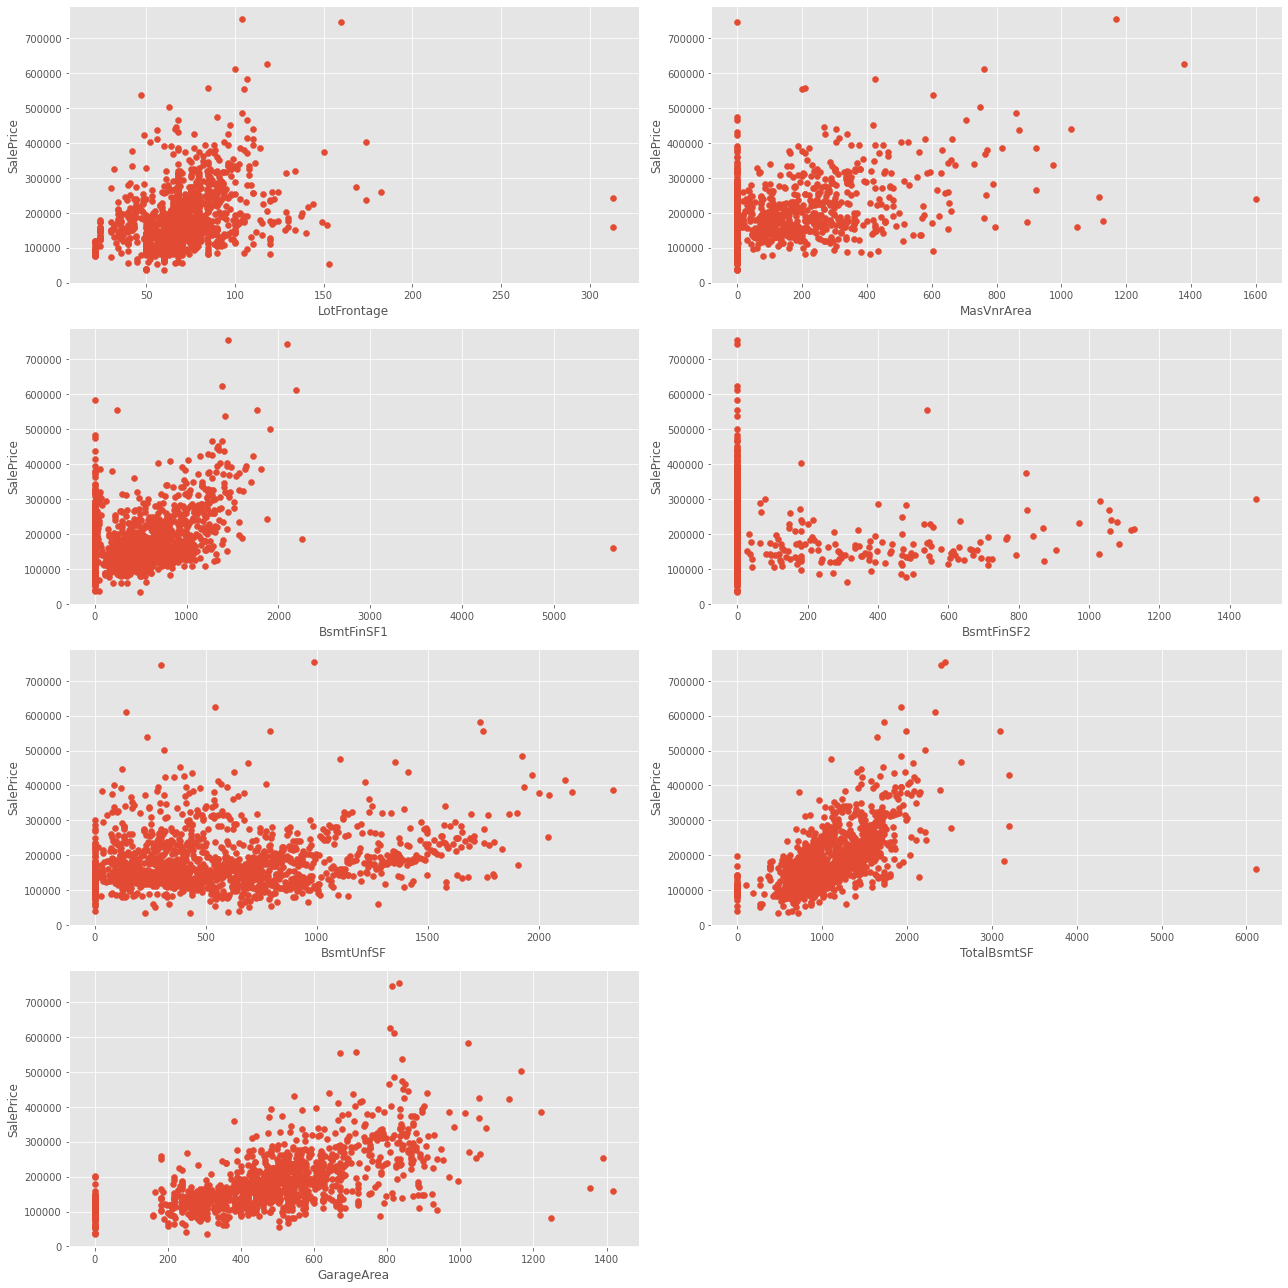

In [21]:
# outliers
num_features = [col for col in train.iloc[:, 1:-1].columns if df_train[col].dtype == 'float']
count = 1
plt.style.use('ggplot')
fig = plt.figure(figsize=(18, 18))
for col in df_train[num_features].columns:
    fig.add_subplot(4, 2, count)
    plt.scatter(df_train[col], train['SalePrice'])
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    count += 1
fig.tight_layout()
plt.show()

In [22]:
# removing outliers
df_train['SalePrice'] = train['SalePrice']
lines_to_remove = list(set(list(df_train[df_train.LotFrontage > 300].index) + \
                    list(df_train[df_train.BsmtFinSF1 > 5000].index) + \
                    list(df_train[df_train.TotalBsmtSF > 6000].index) + \
                    list(df_train[(df_train.GarageArea > 1200) & (df_train.SalePrice < 320000)].index)))
df_train.drop(df_train.index[lines_to_remove], inplace=True)

y = df_train['SalePrice']
df_train = df_train.iloc[:, :-1]
df_train.shape, y.shape

((1455, 94), (1455,))

In [23]:
# transform target
y = np.log(y)

### CatBoost model

In [24]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

cbr = CatBoostRegressor(iterations=700, 
                        learning_rate=0.045, 
                        one_hot_max_size=3,
                        depth=6, 
                        loss_function='RMSE',
                        leaf_estimation_method='Newton',
                        od_type='Iter',
                        od_wait=20,
                       random_state=42)

x_train, x_test, y_train, y_test = train_test_split(df_train, y, random_state=42)
cbr.fit(x_train, y_train,
        cat_features = obj_features,
        logging_level='Silent',
        eval_set = (x_test, y_test))
y_pred = cbr.predict(x_test)
mse(y_test, y_pred)

0.013598468559855971

In [25]:
cbr.best_iteration_

352

In [26]:
# making submission
cbr.fit(df_train, y, 
        cat_features = obj_features, 
        logging_level="Silent")

submission_data = {'Id': test.Id, 'SalePrice': np.exp(cbr.predict(df_test))}
submission = pd.DataFrame(submission_data)
submission.to_csv('submission.csv', index = False)